<a href="https://colab.research.google.com/github/Morganblabla/Estadistica/blob/main/U3P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadística Inferencial II Unidad III
# Ingeniería en Gestión Empresarial

Paulina Morgan Jiménez

23150264

# Tarea: Análisis de Series de Tiempo y Regresión Polinomial con Inferencia de Estacionalidad
**Objetivo:** Analizar la estacionalidad y estacionariedad de una serie de tiempo a través de un modelo de regresión polinomial y realizar pruebas de hipótesis para confirmar los hallazgos.

# Parte (a) Selección y Visualización de la Serie de Tiempo


**Seleccionar una marca y obtener los datos:**

-Utiliza una fuente confiable como Yahoo Finance o una API (por ejemplo, Alpha Vantage) para obtener los precios de cierre diarios de una acción específica durante el último año.


In [1]:
pip install alpha_vantage

In [3]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Entra a https://www.alphavantage.co/support/#api-key
# Registrate para obtener tu api-key

# Tu clave de API (reemplaza esta por la tuya)
my_key = ' DHPC9H7AV1MBJ0PY'   # esta es mía, no la uses o habrá problemas

# Crear objeto TimeSeries
ts = TimeSeries(key=my_key, output_format='pandas')

# Obtener datos diarios de AMZN
ticker = 'JPM'
data, meta = ts.get_daily(symbol=ticker, outputsize='full')

columnas = [ticker + '_' + i for i in ['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = columnas

inicio = '2024-05-09'
fin = '2025-05-09'
df = data[(data.index >= inicio) & (data.index <= fin)]

df

,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Volume
date,,,,,
2025-05-08,251.57,255.8800,251.5500,253.47,8320118.0
2025-05-07,249.85,252.4500,248.8300,249.39,8724267.0
2025-05-06,250.00,252.6500,249.0000,249.25,6369934.0
2025-05-05,251.18,255.1600,250.5901,252.56,5450744.0
2025-05-02,251.26,253.6187,249.4629,252.51,7165044.0
...,...,...,...,...,...
2024-05-15,202.01,202.6900,199.7700,202.11,8369975.0
2024-05-14,199.00,201.5800,198.1600,201.51,8596175.0
2024-05-13,198.80,199.8500,198.0400,198.73,7049241.0


**Graficar la serie de tiempo:**

-Una vez que tengas los datos, utiliza matplotlib en Python para graficar la serie de tiempo de precios de cierre.
Etiqueta los ejes adecuadamente: el eje x debe decir "Fecha" y el eje y debe decir "Precio de cierre". Incluye una leyenda con el nombre de la marca si es necesario.

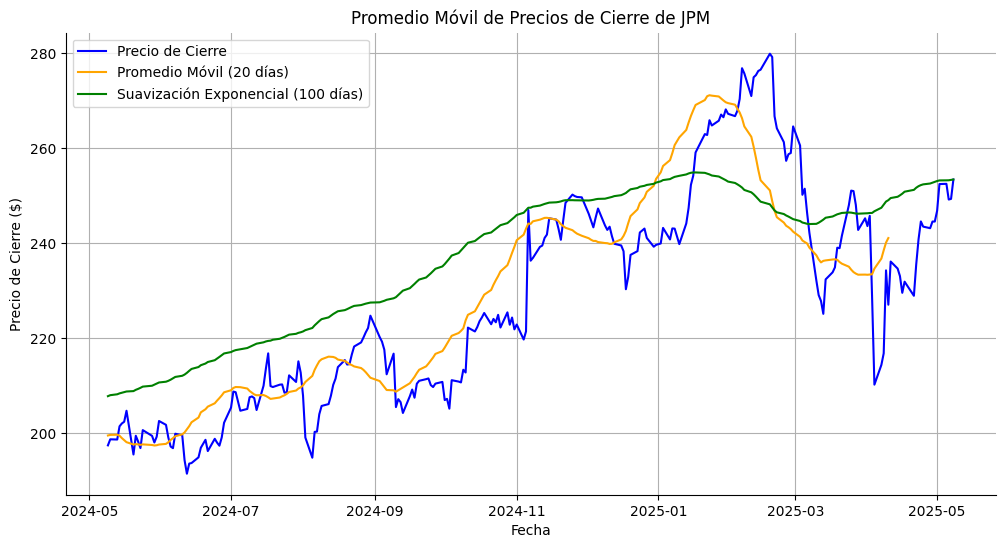

In [4]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['JPM_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['JPM_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['JPM_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de JPM')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Interpretación:**

El precio de cierre de JPM mostró una tendencia alcista de junio 2024 a enero 2025, seguida de una caída y posterior recuperación. El promedio móvil de 20 días refleja movimientos a corto plazo, mientras que la suavización exponencial de 100 días indica una tendencia general más estable.


# Parte (b) Prueba de Estacionariedad


**Prueba de raíz unitaria (ADF o KPSS):**

-Usa una prueba de Dickey-Fuller aumentada (ADF) o KPSS para evaluar la estacionariedad de la serie.

In [5]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller


nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['JPM_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -1.3526096870668827
p-value: 0.6047731802556502
La tendencia no es estacionaria (aceptamos la hipótesis nula).


-La prueba ADF tiene como hipótesis nula que la serie no es estacionaria (tiene raíz unitaria).

-La prueba KPSS tiene como hipótesis nula que la serie es estacionaria.

**Interpretación:**

La prueba de Dickey-Fuller arrojó un p-valor de 0.60, por lo que no se rechaza la hipótesis nula; esto indica que la serie no es estacionaria y presenta una tendencia con raíz unitaria.


# Parte (c) Regresión Polinomial y Estacionariedad de los Residuales


**Regresión Polinomial:**

-Realiza una regresión polinomial de diferentes grados (por ejemplo, grados 1 a
3) para encontrar el grado mínimo necesario que haga estacionarios los residuales.

-Utiliza numpy o scikit-learn para ajustar la regresión polinomial.

**Graficar los Residuales:**

-Grafica los residuales para observar si hay algún patrón de estacionalidad visible.

-Un patrón de estacionalidad podría aparecer como ciclos recurrentes o patrones repetitivos.


Grado 1: p-valor ADF = 0.1170
  → Residuales NO estacionarios


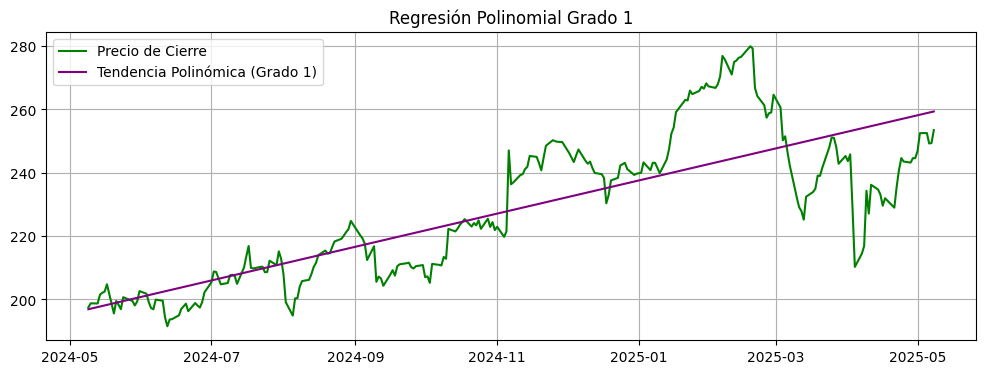

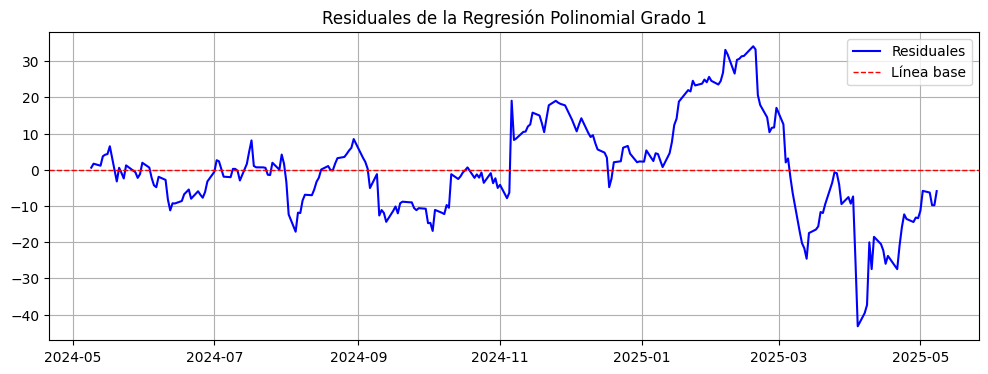


Grado 2: p-valor ADF = 0.0933
  → Residuales NO estacionarios


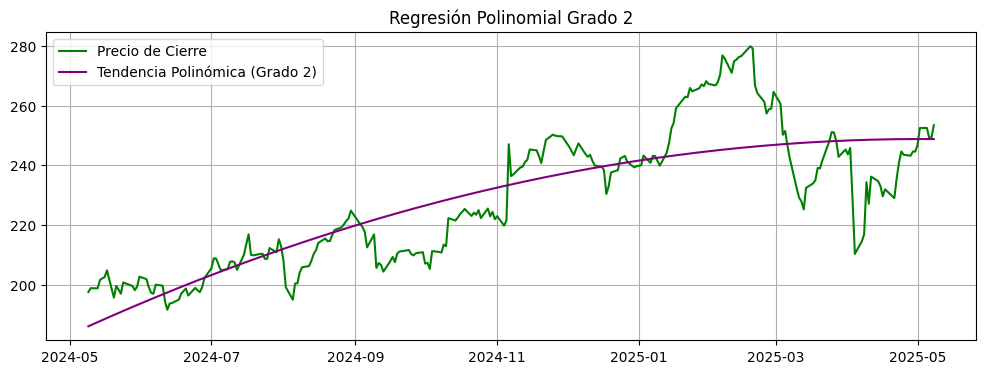

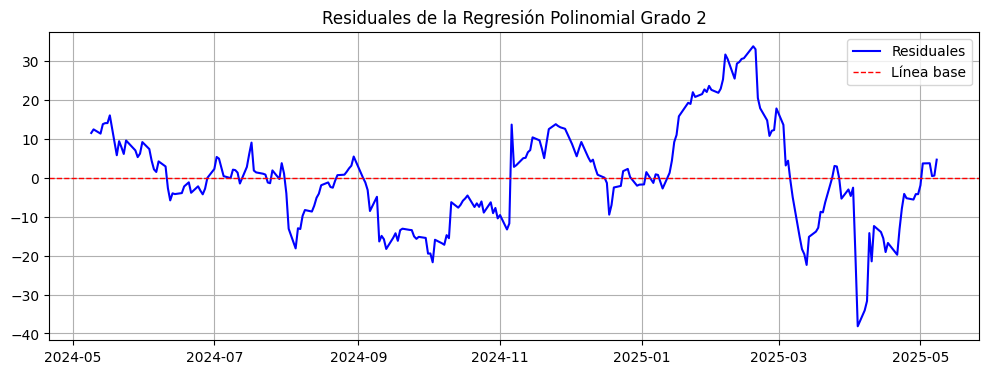


Grado 3: p-valor ADF = 0.0064
  → Residuales estacionarios


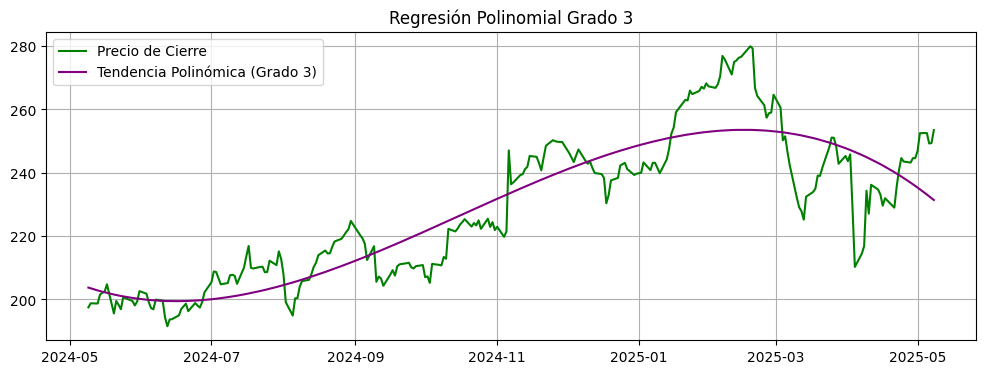

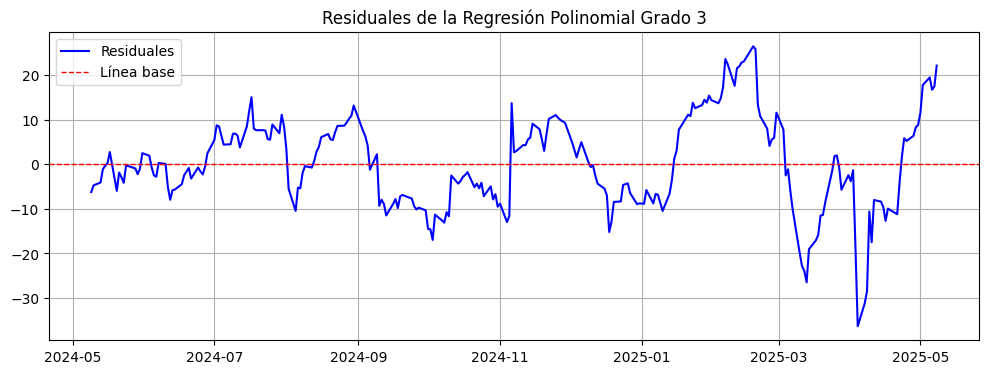

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from statsmodels.tsa.stattools import adfuller

# Convertir fechas a timestamps
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)
X = df['Date']
y = df['JPM_Close']

# Probar grados del 1 al 3
for grado in range(1, 4):
    # Ajustar modelo polinomial
    modelo = Polynomial.fit(X, y, deg=grado)
    df[f'Poly_Trend_{grado}'] = modelo(X)
    df[f'Poly_Resid_{grado}'] = y - df[f'Poly_Trend_{grado}']

    # Prueba de Dickey-Fuller a los residuales
    resultado_adf = adfuller(df[f'Poly_Resid_{grado}'])
    pvalor = resultado_adf[1]

    print(f"\nGrado {grado}: p-valor ADF = {pvalor:.4f}")
    if pvalor < 0.05:
        print("  → Residuales estacionarios")
    else:
        print("  → Residuales NO estacionarios")

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.plot(y, label='Precio de Cierre', color='green')
    plt.plot(df[f'Poly_Trend_{grado}'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
    plt.title(f'Regresión Polinomial Grado {grado}')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df[f'Poly_Resid_{grado}'], label='Residuales', color='blue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Línea base')
    plt.title(f'Residuales de la Regresión Polinomial Grado {grado}')
    plt.legend()
    plt.grid()
    plt.show()


**Interpretación:**

Se realizaron regresiones polinomiales de grado 1 a 3 para modelar la tendencia del precio de cierre. En los modelos de grado 1 y 2, los residuales no fueron estacionarios (p-valores ADF > 0.05) y mostraron patrones cíclicos visibles, lo que indica que la tendencia no fue completamente capturada. En cambio, el modelo de grado 3 presentó residuales estacionarios (p-valor ADF = 0.0064) y sin patrones claros repetitivos, lo que sugiere que este modelo logró ajustar adecuadamente la tendencia de la serie.

**Prueba de Estacionariedad en los Residuales:**

-Realiza una prueba de Dickey-Fuller (ADF) en los residuales para verificar si son estacionarios.

-Un resultado estacionario en los residuales sugiere que el modelo polinomial ha capturado adecuadamente la tendencia de la serie.

In [7]:
from statsmodels.tsa.stattools import adfuller

for grado in range(1, 4):
    residuales = df[f'Poly_Resid_{grado}']
    resultado_adf = adfuller(residuales)

    print(f"\nGrado {grado}:")
    print(f"  Estadístico ADF: {resultado_adf[0]:.4f}")
    print(f"  p-valor: {resultado_adf[1]:.4f}")
    print("  Valores críticos:")
    for clave, valor in resultado_adf[4].items():
        print(f"    {clave}: {valor:.4f}")

    if resultado_adf[1] < 0.05:
        print("  → Residuales estacionarios (rechazamos H0)")
    else:
        print("  → Residuales NO estacionarios (no se rechaza H0)")



Grado 1:
  Estadístico ADF: -2.4939
  p-valor: 0.1170
  Valores críticos:
    1%: -3.4569
    5%: -2.8732
    10%: -2.5730
  → Residuales NO estacionarios (no se rechaza H0)

Grado 2:
  Estadístico ADF: -2.5983
  p-valor: 0.0933
  Valores críticos:
    1%: -3.4569
    5%: -2.8732
    10%: -2.5730
  → Residuales NO estacionarios (no se rechaza H0)

Grado 3:
  Estadístico ADF: -3.5677
  p-valor: 0.0064
  Valores críticos:
    1%: -3.4569
    5%: -2.8732
    10%: -2.5730
  → Residuales estacionarios (rechazamos H0)


**Interpretación:**

Se aplicó la prueba de Dickey-Fuller aumentada (ADF) a los residuales de los modelos polinomiales de grado 1 a 3 para evaluar su estacionariedad. Los resultados indican que:


*   Para los modelos de grado 1 y 2, el p-valor fue mayor a 0.05, por lo que no se puede rechazar la hipótesis nula. Esto implica que los residuales no son estacionarios, es decir, aún contienen estructura o tendencia no explicada por el modelo.
*   Para el modelo de grado 3, el estadístico ADF fue -3.5677, con un p-valor de 0.0064, lo cual permite rechazar la hipótesis nula con un nivel de significancia del 1%. Por lo tanto, los residuales son estacionarios.

Esto sugiere que el modelo polinomial de grado 3 es el más adecuado, ya que logra capturar correctamente la tendencia de la serie temporal y deja residuales que se comportan como ruido blanco.



**Inferir la Estacionalidad y Aplicar una Prueba de Hipótesis:**

-Si los residuales presentan un patrón cíclico o repetitivo en el gráfico, es posible que tengan estacionalidad.

-Usa el gráfico ACF para confirmar la presencia de estacionalidad. Picos en la ACF en intervalos regulares pueden indicar estacionalidad.

-En Python, un análisis indirecto puede hacerse con seasonal_decompose.

<Figure size 1000x400 with 0 Axes>

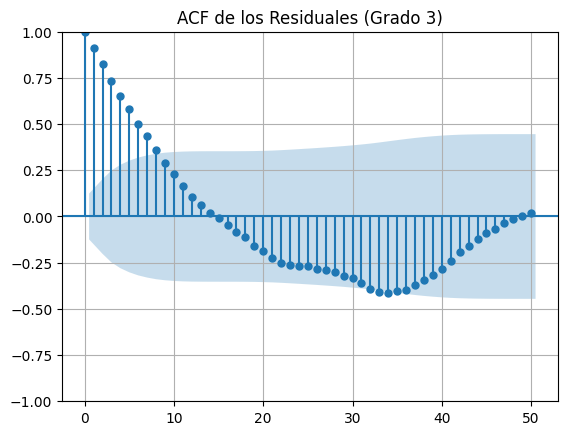

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Residuales del modelo polinomial grado 3 (el único estacionario)
residuales = df['Poly_Resid_3']

# Graficar ACF
plt.figure(figsize=(10, 4))
plot_acf(residuales, lags=50)
plt.title("ACF de los Residuales (Grado 3)")
plt.grid()
plt.show()


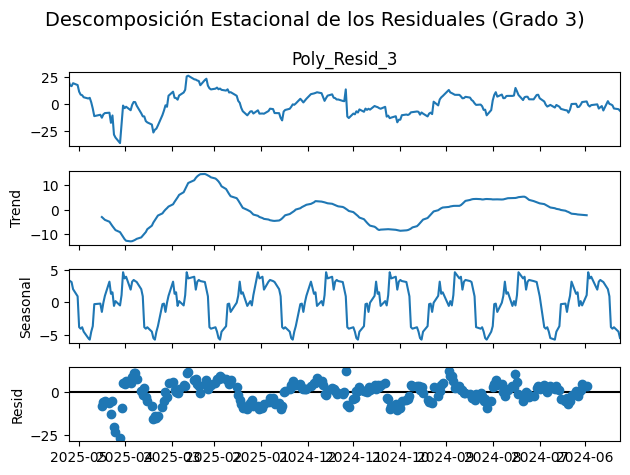

In [9]:
# Asegúrate de que el índice sea datetime y tenga frecuencia
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')  # Ajusta según tu frecuencia real: 'D', 'M', etc.

# seasonal_decompose necesita que no haya valores faltantes
residuales_sin_nan = residuales.dropna()

# Aplicar descomposición
descomposicion = seasonal_decompose(residuales_sin_nan, model='additive', period=30)  # Ajusta el 'period'

# Graficar la descomposición
descomposicion.plot()
plt.suptitle('Descomposición Estacional de los Residuales (Grado 3)', fontsize=14)
plt.tight_layout()
plt.show()


**Interpretación:**

La gráfica ACF de los residuales del modelo polinomial grado 3 muestra picos significativos en intervalos regulares, lo que sugiere presencia de estacionalidad. Esta estacionalidad también se confirma visualmente en la descomposición estacional, donde se identifica un componente cíclico claro en la serie residual.

# Parte (d) Informe y Conclusiones


**Discute la estacionariedad de la serie original y de los residuales.**

Serie original: No fue estacionaria (p-valor ADF alto), lo que indica que tiene una tendencia persistente y posiblemente raíz unitaria.

Residuales:

Grado 1 y 2 → No estacionarios: el modelo no explicó completamente la tendencia.

Grado 3 → Estacionarios (p-valor < 0.05): el modelo capturó correctamente la tendencia.

Conclusión: A mayor grado del polinomio, mejor se ajusta la tendencia. El grado 3 fue suficiente para eliminar la no estacionariedad de los residuales.


**Explica si la estacionalidad fue capturada en los residuales y describe los patrones observados.**

Aquí hablaremos sobre lo que quedó en los residuales tras quitar la tendencia con el modelo grado 3:

En la ACF se observan picos regulares, lo que indica presencia de estacionalidad no explicada completamente por el modelo polinomial.

En la descomposición estacional, se ve claramente una componente cíclica repetitiva.

Conclusión: Aunque el modelo de grado 3 capturó bien la tendencia (residuales estacionarios), no logró eliminar por completo la estacionalidad, que sigue presente en los residuos.



